<class 'pandas.core.frame.DataFrame'>
Index: 1637 entries, 0 to 1636
Data columns (total 6 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Year                1637 non-null   int64  
 1   Trimester           1637 non-null   int64  
 2   District            1637 non-null   object 
 3   Neighbourhood       1637 non-null   object 
 4   Price (euro/month)  1637 non-null   float64
 5   Price (euro/m2)     1637 non-null   float64
dtypes: float64(2), int64(2), object(2)
memory usage: 89.5+ KB
None
              Year    Trimester  Price (euro/month)  Price (euro/m2)
count  1637.000000  1637.000000         1637.000000      1637.000000
mean   2016.487477     2.499084          788.373366        11.742211
std       1.704480     1.117555          257.074112         2.490496
min    2014.000000     1.000000          142.340000         3.180000
25%    2015.000000     2.000000          621.430000        10.000000
50%    2016.000000     2.

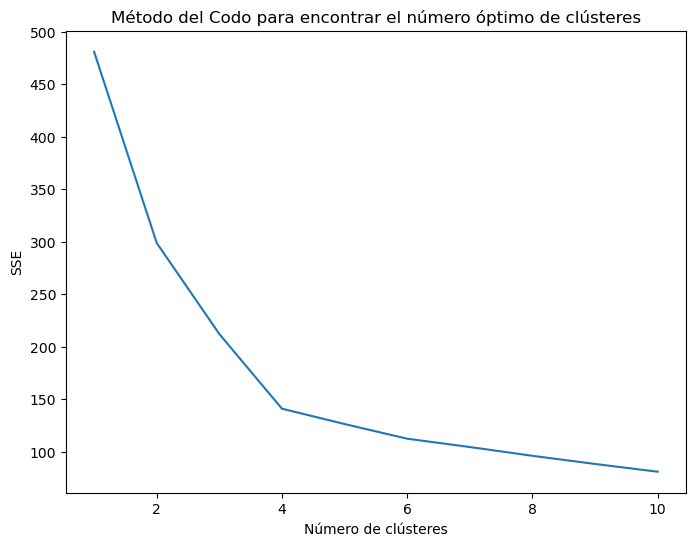

/var/folders/7c/3smlgk813_l8xy5r_2zy0trr0000gn/T/ipykernel_13795/2347474203.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_filtered['Cluster'] = clusters
/var/folders/7c/3smlgk813_l8xy5r_2zy0trr0000gn/T/ipykernel_13795/2347474203.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_filtered['Distance_to_Centroid'] = np.linalg.norm(data_scaled - kmeans.cluster_centers_[clusters], axis=1)
/var/folders/7c/3smlgk813_l8xy5r_2zy0trr0000gn/T/ipykernel_13795/2347474203.py:49: SettingWithCopyWarning:

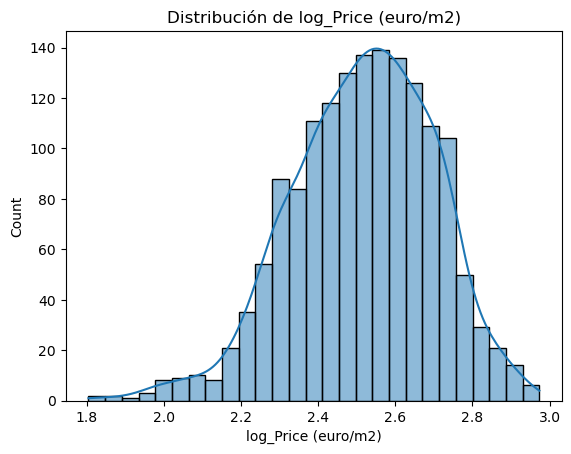

MAE: 0.5166244686783166, MSE: 0.5161663485344443, RMSE: 0.718447178666911, R²: 0.907716175525502
Validación cruzada R²: 0.8998923745334875, 0.012105058209267038
      Year  Trimester      District  \
1637  2020          1  Ciutat Vella   
1638  2020          1  Ciutat Vella   
1639  2020          1  Ciutat Vella   
1640  2020          1  Ciutat Vella   
1641  2020          1      Eixample   
...    ...        ...           ...   
2306  2022          2    Sant Marti   
2307  2022          2    Sant Marti   
2308  2022          2    Sant Marti   
2309  2022          2    Sant Marti   
2310  2022          2    Sant Marti   

                                     Neighbourhood  Predicted Price (euro/m2)  
1637                                      el Raval                  15.225776  
1638                                Gothic Quarter                  15.633721  
1639                                la Barceloneta                  19.576171  
1640         Sant Pere, Santa Caterina i la Ribera

/var/folders/7c/3smlgk813_l8xy5r_2zy0trr0000gn/T/ipykernel_13795/2347474203.py:108: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  years_pandemic['Predicted Price (euro/m2)'] = predictions_pandemic


In [1]:
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.cluster import KMeans

# Cargar los datos
data = pd.read_csv("./Barcelona_rent_price.csv", delimiter=';')

# Filtrar los datos excluyendo los años 2020, 2021 y 2022
data_filtered = data[data['Year'] < 2020]

# Análisis Exploratorio de Datos (EDA)
print(data_filtered.info())
print(data_filtered.describe())

# Identificar y corregir outliers utilizando K-means clustering
numeric_data = data_filtered.select_dtypes(include=['float64', 'int64'])
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(numeric_data)

# Calcular SSE para diferentes valores de k
sse = {}
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(data_scaled)
    sse[k] = kmeans.inertia_

# Graficar SSE vs. k para encontrar el número óptimo de clústeres
plt.figure(figsize=(8, 6))
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Número de clústeres")
plt.ylabel("SSE")
plt.title("Método del Codo para encontrar el número óptimo de clústeres")
plt.show()

# Aplicar K-means clustering con 4 clústeres (según el gráfico del codo)
kmeans = KMeans(n_clusters=4, random_state=42)
clusters = kmeans.fit_predict(data_scaled)
data_filtered['Cluster'] = clusters
data_filtered['Distance_to_Centroid'] = np.linalg.norm(data_scaled - kmeans.cluster_centers_[clusters], axis=1)
threshold = data_filtered['Distance_to_Centroid'].quantile(0.95)
data_filtered['Is_Outlier'] = data_filtered['Distance_to_Centroid'] > threshold

# Eliminar outliers
data_clean = data_filtered[~data_filtered['Is_Outlier']]

# Aplicar transformación logarítmica
data_clean['log_Price (euro/m2)'] = np.log1p(data_clean['Price (euro/m2)'])

# Visualizar la distribución después de la transformación
sns.histplot(data_clean['log_Price (euro/m2)'], kde=True)
plt.title('Distribución de log_Price (euro/m2)')
plt.show()

# Binarización de variables categóricas
data_encoded = pd.get_dummies(data_clean, columns=['District', 'Neighbourhood'])

# División en características (X) y variable objetivo transformada (y)
X = data_encoded.drop(['Price (euro/m2)', 'log_Price (euro/m2)'], axis=1)
y = data_encoded['log_Price (euro/m2)']

# Escalado de los datos
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# División en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Entrenar y evaluar el modelo Ridge
ridge_model = Ridge(alpha=1.0)
ridge_model.fit(X_train, y_train)
y_pred_log = ridge_model.predict(X_test)
y_pred = np.expm1(y_pred_log)  # Deshacer la transformación logarítmica
y_test_exp = np.expm1(y_test)

mae = mean_absolute_error(y_test_exp, y_pred)
mse = mean_squared_error(y_test_exp, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test_exp, y_pred)

print(f'MAE: {mae}, MSE: {mse}, RMSE: {rmse}, R²: {r2}')

# Validación cruzada con KFold
kf = KFold(n_splits=5, shuffle=True, random_state=42)
scores = cross_val_score(ridge_model, X_train, y_train, cv=kf, scoring='r2', n_jobs=-1)
print(f'Validación cruzada R²: {scores.mean()}, {scores.std()}')

# Predicción para los años de la pandemia (2020, 2021, 2022)
years_pandemic = data[(data['Year'] == 2020) | (data['Year'] == 2021) | (data['Year'] == 2022)]
years_pandemic_encoded = pd.get_dummies(years_pandemic, columns=['District', 'Neighbourhood'])
missing_cols = set(X.columns) - set(years_pandemic_encoded.columns)
for c in missing_cols:
    years_pandemic_encoded[c] = 0
years_pandemic_encoded = years_pandemic_encoded.loc[:, ~years_pandemic_encoded.columns.duplicated()]
years_pandemic_encoded = years_pandemic_encoded.reindex(columns=X.columns, fill_value=0)
years_pandemic_scaled = scaler.transform(years_pandemic_encoded)

# Realizar la predicción para los años de la pandemia
predictions_pandemic_log = ridge_model.predict(years_pandemic_scaled)
predictions_pandemic = np.expm1(predictions_pandemic_log)  # Deshacer la transformación logarítmica
years_pandemic['Predicted Price (euro/m2)'] = predictions_pandemic

# Mostrar las predicciones para los años de la pandemia
print(years_pandemic[['Year', 'Trimester', 'District', 'Neighbourhood', 'Predicted Price (euro/m2)']])

# Guardar las predicciones en un archivo CSV
years_pandemic.to_csv('predictions_pandemic_2020_2022.csv', index=False)


Descripción estadística de los datos originales:
              Year    Trimester  Price (euro/month)  Price (euro/m2)
count  2311.000000  2311.000000         2311.000000      2311.000000
mean   2017.745565     2.440502          820.780658        12.134531
std       2.463095     1.116498          255.450568         2.419414
min    2014.000000     1.000000          142.340000         3.180000
25%    2016.000000     1.000000          653.860000        10.500000
50%    2018.000000     2.000000          777.210000        12.100000
75%    2020.000000     3.000000          926.500000        13.750000
max    2022.000000     4.000000         2034.000000        21.300000

Descripción estadística de las predicciones:
              Year   Trimester  Price (euro/month)  Price (euro/m2)  \
count   674.000000  674.000000          674.000000       674.000000   
mean   2020.801187    2.298220          899.490950        13.087389   
std       0.748807    1.101841          233.602418         1.931372   


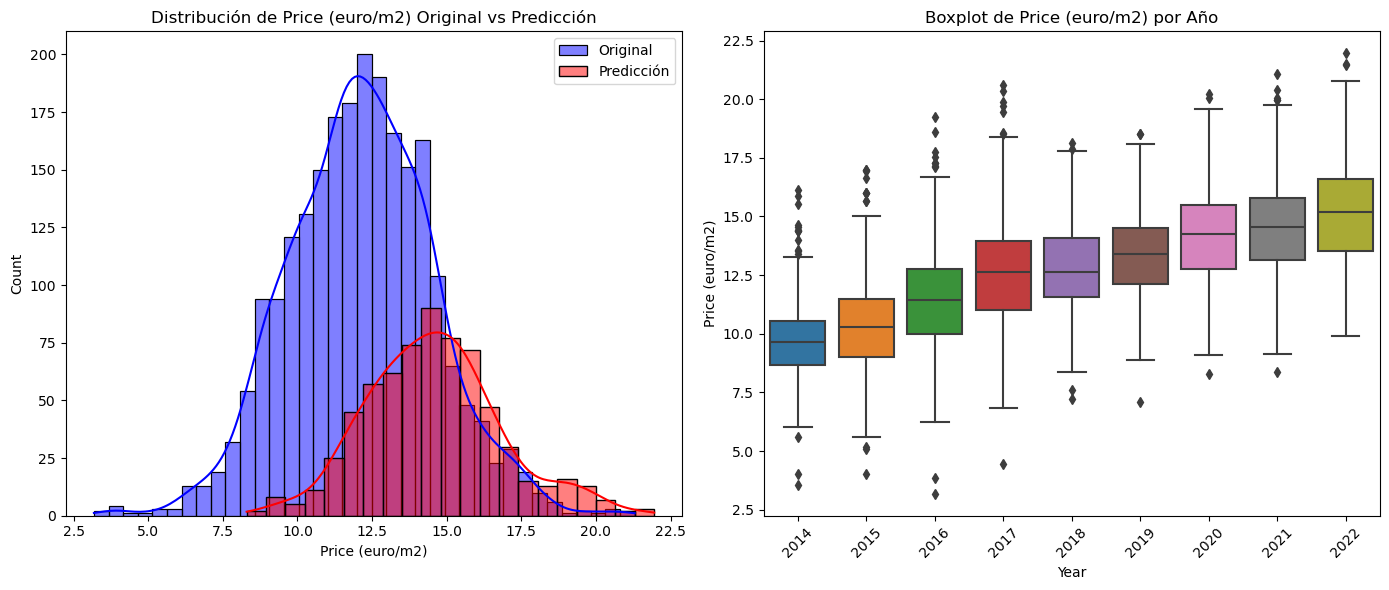

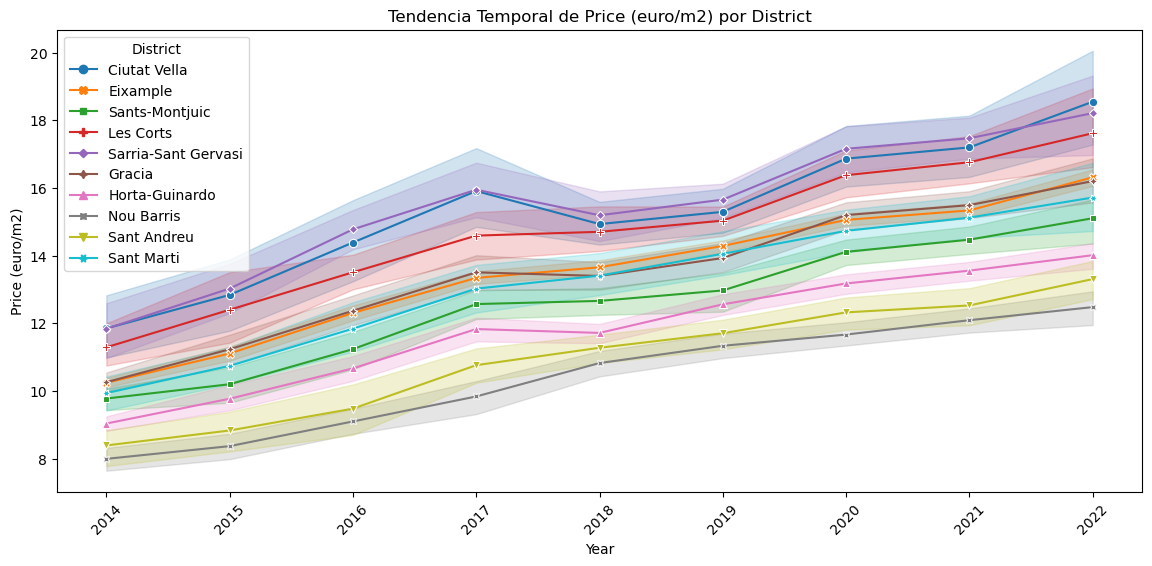

Media antes de 2020: 11.74, Desviación estándar antes de 2020: 2.49
Media después de 2020: 14.58, Desviación estándar después de 2020: 2.28
Media de los años de la pandemia (2020-2022): 14.58, Desviación estándar de los años de la pandemia: 2.28


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Cargar las predicciones de los años de la pandemia
predictions_pandemic = pd.read_csv('predictions_pandemic_2020_2022.csv')

# Unir los datos originales con las predicciones
data_with_predictions = pd.concat([data, predictions_pandemic[['Year', 'Trimester', 'District', 'Neighbourhood', 'Predicted Price (euro/m2)']]], ignore_index=True)

# Reemplazar los valores originales por las predicciones en los años de la pandemia
data_with_predictions['Price (euro/m2)'] = np.where(
    (data_with_predictions['Year'] >= 2020) & (data_with_predictions['Year'] <= 2022),
    data_with_predictions['Predicted Price (euro/m2)'],
    data_with_predictions['Price (euro/m2)']
)

# Descripción estadística de los datos originales y predicciones
print("Descripción estadística de los datos originales:")
print(data.describe())

print("\nDescripción estadística de las predicciones:")
print(predictions_pandemic.describe())

# Gráficos de distribución
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
sns.histplot(data['Price (euro/m2)'], kde=True, color='blue', label='Original')
sns.histplot(predictions_pandemic['Predicted Price (euro/m2)'], kde=True, color='red', label='Predicción')
plt.title('Distribución de Price (euro/m2) Original vs Predicción')
plt.legend()

plt.subplot(1, 2, 2)
sns.boxplot(data=data_with_predictions, x='Year', y='Price (euro/m2)')
plt.title('Boxplot de Price (euro/m2) por Año')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

# Gráficos de tendencia temporal
plt.figure(figsize=(14, 6))
sns.lineplot(data=data_with_predictions, x='Year', y='Price (euro/m2)', hue='District', style='District', markers=True, dashes=False)
plt.title('Tendencia Temporal de Price (euro/m2) por District')
plt.xticks(rotation=45)
plt.show()

# Comparación de la media y desviación estándar de los precios antes y después de la predicción
mean_before = data[data['Year'] < 2020]['Price (euro/m2)'].mean()
std_before = data[data['Year'] < 2020]['Price (euro/m2)'].std()
mean_after = predictions_pandemic['Predicted Price (euro/m2)'].mean()
std_after = predictions_pandemic['Predicted Price (euro/m2)'].std()

print(f"Media antes de 2020: {mean_before:.2f}, Desviación estándar antes de 2020: {std_before:.2f}")
print(f"Media después de 2020: {mean_after:.2f}, Desviación estándar después de 2020: {std_after:.2f}")

# Comparación de la media y desviación estándar de los precios de los años 2020 a 2022
mean_pandemic = predictions_pandemic['Predicted Price (euro/m2)'].mean()
std_pandemic = predictions_pandemic['Predicted Price (euro/m2)'].std()

print(f"Media de los años de la pandemia (2020-2022): {mean_pandemic:.2f}, Desviación estándar de los años de la pandemia: {std_pandemic:.2f}")


In [3]:
import pandas as pd

# Cargar los datos originales
data = pd.read_csv("./Barcelona_rent_price.csv", delimiter=';')

# Cargar las predicciones de los años de la pandemia
predictions_pandemic = pd.read_csv('predictions_pandemic_2020_2022.csv')

# Unir los datos originales con las predicciones
data_with_predictions = data.copy()
data_with_predictions = data_with_predictions.merge(
    predictions_pandemic[['Year', 'Trimester', 'District', 'Neighbourhood', 'Predicted Price (euro/m2)']],
    on=['Year', 'Trimester', 'District', 'Neighbourhood'],
    how='left'
)

# Reemplazar los valores originales por las predicciones en los años de la pandemia
data_with_predictions['Price (euro/m2)'] = np.where(
    ~data_with_predictions['Predicted Price (euro/m2)'].isna(),
    data_with_predictions['Predicted Price (euro/m2)'],
    data_with_predictions['Price (euro/m2)']
)

# Eliminar la columna de predicciones
data_with_predictions = data_with_predictions.drop(columns=['Predicted Price (euro/m2)'])

# Guardar el conjunto de datos actualizado en un nuevo archivo CSV
data_with_predictions.to_csv('Barcelona_rent_price_updated.csv', index=False)

print("Archivo actualizado guardado como 'Barcelona_rent_price_updated.csv'")


Archivo actualizado guardado como 'Barcelona_rent_price_updated.csv'


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2311 entries, 0 to 2310
Data columns (total 6 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Year                2311 non-null   int64  
 1   Trimester           2311 non-null   int64  
 2   District            2311 non-null   object 
 3   Neighbourhood       2311 non-null   object 
 4   Price (euro/month)  2311 non-null   float64
 5   Price (euro/m2)     2311 non-null   float64
dtypes: float64(2), int64(2), object(2)
memory usage: 108.5+ KB
None
              Year    Trimester  Price (euro/month)  Price (euro/m2)
count  2311.000000  2311.000000         2311.000000      2311.000000
mean   2017.745565     2.440502          820.780658        12.569469
std       2.463095     1.116498          255.450568         2.750275
min    2014.000000     1.000000          142.340000         3.180000
25%    2016.000000     1.000000          653.860000        10.600000
50%    2018.000000 

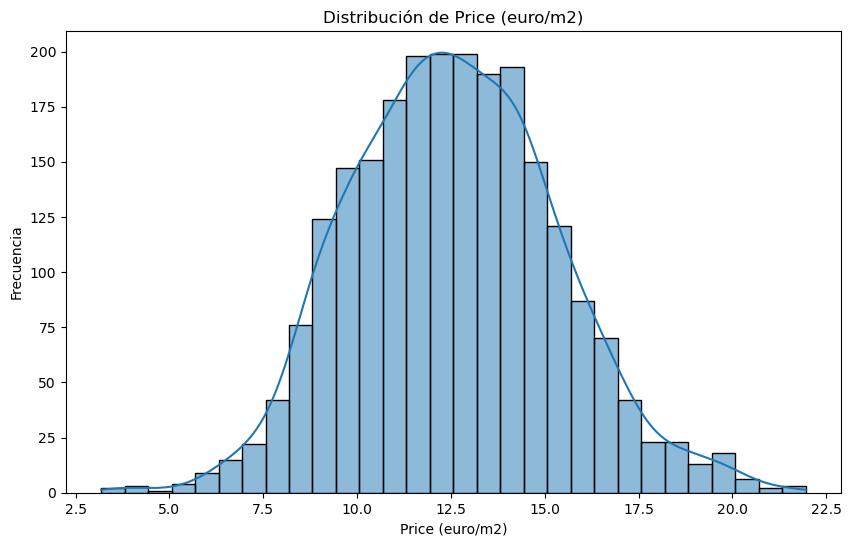

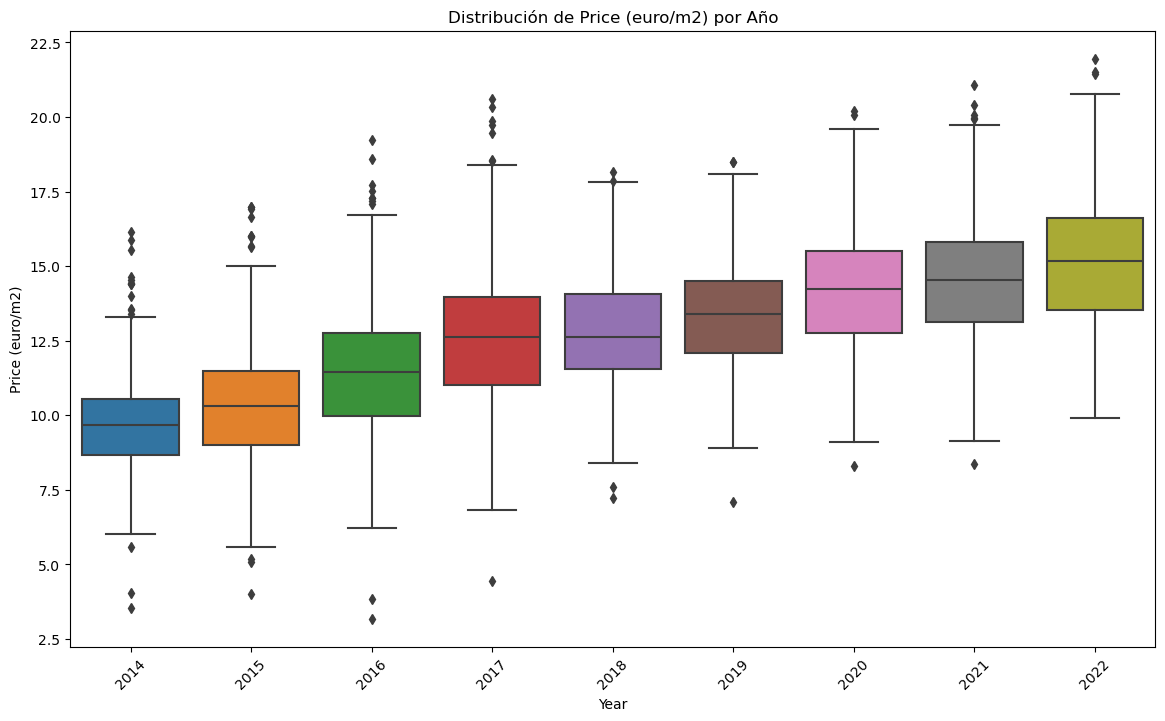

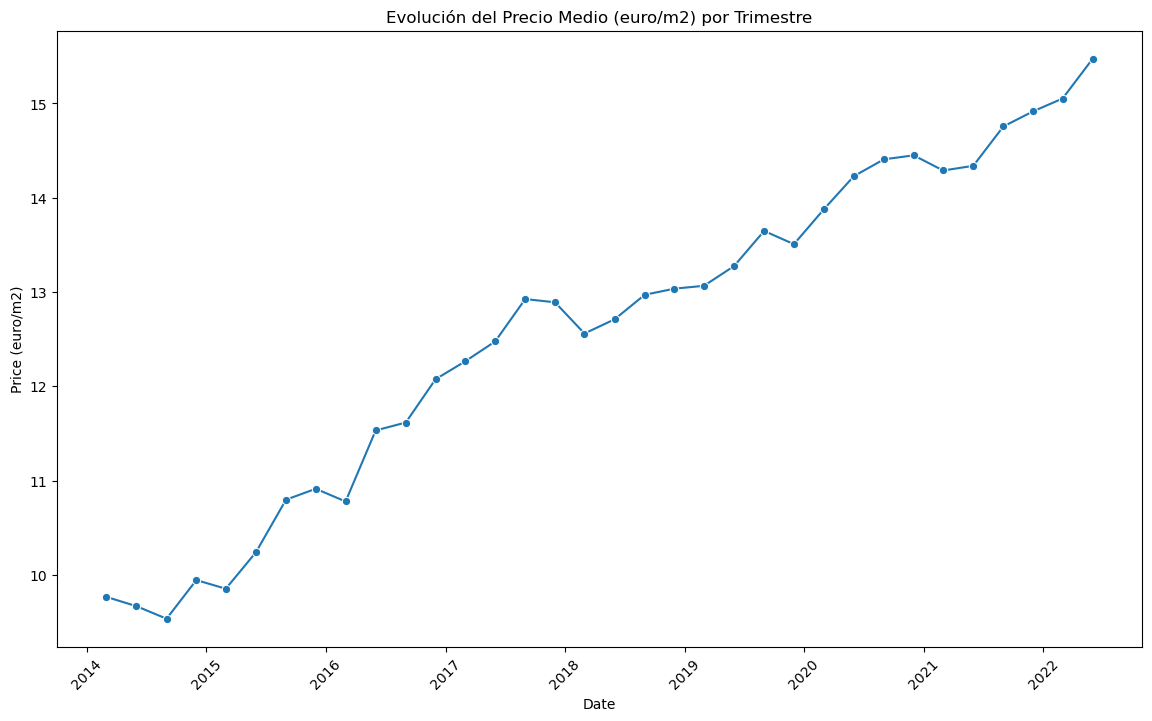

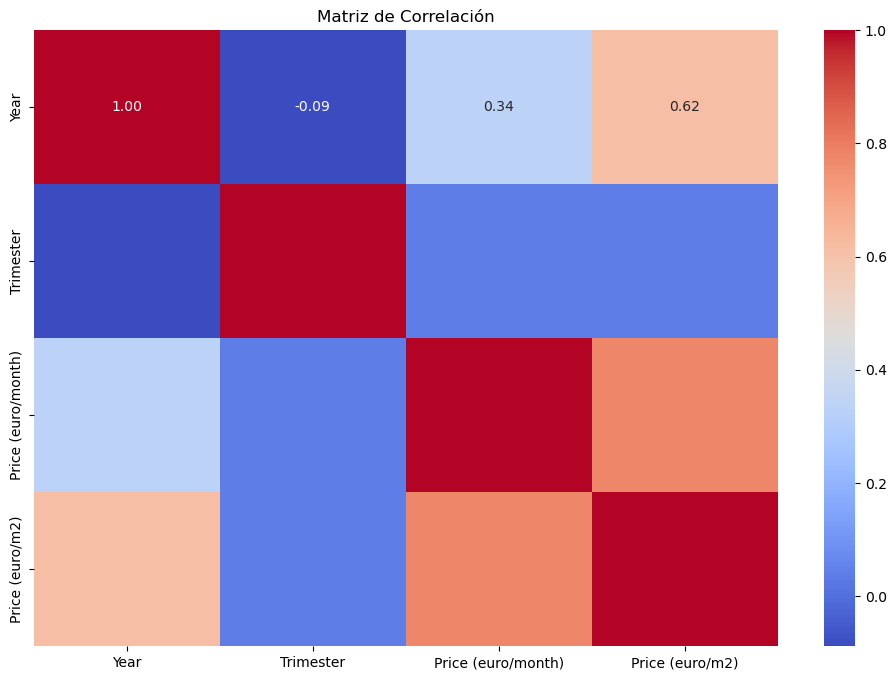

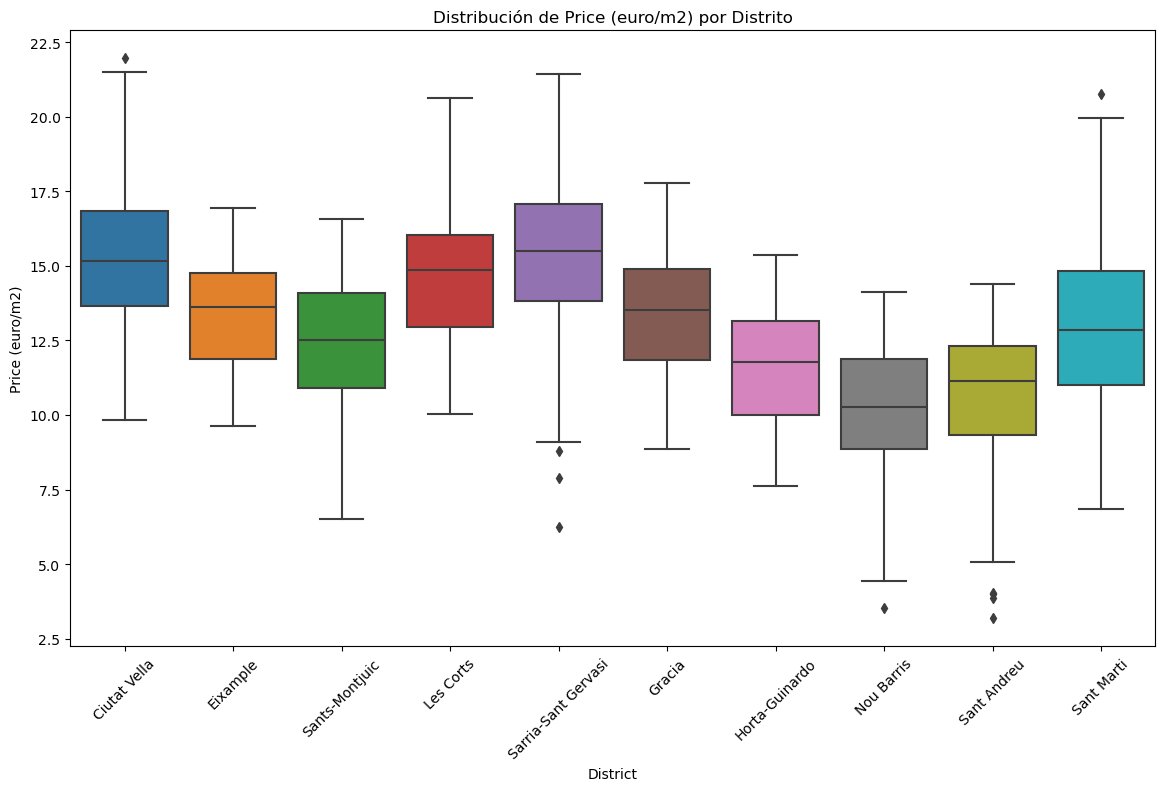

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Cargar el archivo actualizado
data_updated = pd.read_csv('Barcelona_rent_price_updated.csv')

# Mostrar información del conjunto de datos
print(data_updated.info())

# Mostrar estadísticas descriptivas
print(data_updated.describe())

# Visualizar la distribución de la variable objetivo
plt.figure(figsize=(10, 6))
sns.histplot(data_updated['Price (euro/m2)'], kde=True, bins=30)
plt.title('Distribución de Price (euro/m2)')
plt.xlabel('Price (euro/m2)')
plt.ylabel('Frecuencia')
plt.show()

# Visualizar la distribución de precios por año
plt.figure(figsize=(14, 8))
sns.boxplot(x='Year', y='Price (euro/m2)', data=data_updated)
plt.title('Distribución de Price (euro/m2) por Año')
plt.xlabel('Year')
plt.ylabel('Price (euro/m2)')
plt.xticks(rotation=45)
plt.show()

# Visualizar la serie temporal del precio medio por trimestre
data_updated['Date'] = pd.to_datetime(data_updated['Year'].astype(str) + '-' + (data_updated['Trimester'] * 3).astype(str) + '-01')
data_time_series = data_updated.groupby('Date')['Price (euro/m2)'].mean().reset_index()

plt.figure(figsize=(14, 8))
sns.lineplot(x='Date', y='Price (euro/m2)', data=data_time_series, marker='o')
plt.title('Evolución del Precio Medio (euro/m2) por Trimestre')
plt.xlabel('Date')
plt.ylabel('Price (euro/m2)')
plt.xticks(rotation=45)
plt.show()

# Análisis de correlación
# Seleccionar solo las columnas numéricas
numeric_columns = data_updated.select_dtypes(include=[np.number])
correlation_matrix = numeric_columns.corr()

plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Matriz de Correlación')
plt.show()

# Visualizar la distribución de precios por distrito
plt.figure(figsize=(14, 8))
sns.boxplot(x='District', y='Price (euro/m2)', data=data_updated)
plt.title('Distribución de Price (euro/m2) por Distrito')
plt.xlabel('District')
plt.ylabel('Price (euro/m2)')
plt.xticks(rotation=45)
plt.show()
